<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning For Maximum Power Point Tracking Prediction In PV System **

Explanation of this project can be found in https://www.mdpi.com/1996-1073/14/22/7806

This notebook does the following:

* **Read data from IBM db2 database.** 
* **Load data into dataframes.**
* **Visuolize the data.**
* **Filter the data.**
* **Loading data into Spark DataFrames**
* **Apply statistics.**
* **Training.**

In [14]:
# Installing required packages

!pip install pyspark
!pip install findspark
import findspark
findspark.init()

!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa==0.3.7

In [15]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from google.colab import files
import io

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

import ibm_db
import ibm_db_sa
import ibm_db_dbi
import sqlalchemy
from sqlalchemy import *

##Connect to the database

### 1) First method

In [17]:
#Replace the placeholder values with your actual Db2 hostname, username, and password:
dsn_hostname = "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "wzw37676"        # e.g. "abc12345"
dsn_pwd = "RqVbtpgxaho1uE5S"      # e.g. "7dBZ3wWt9XN6$o0J"

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "31929"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "ssl"              #i.e. "SSL"

#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd,dsn_security)
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  wzw37676 on host:  55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud


In [18]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)
#query statement to retrieve all rows in INSTRUCTOR table
data1 = "select * from PV_DATA1"
data2 = "select * from PV_DATA2"
data_max = "select * from PV_DATA_MAX"
#retrieve the query results into a pandas dataframe
df1 = pd.read_sql(data1, pconn)
df2 = pd.read_sql(data2, pconn)
df_max = pd.read_sql(data_max, pconn)

### 2) Second method

In [22]:
%load_ext sql

# Enter the connection string for your Db2 on Cloud database instance below
# %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name?security=SSL
%sql ibm_db_sa://wzw37676:RqVbtpgxaho1uE5S@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb?security=SSL 

# Retrieve list of all tables in the database for db2 schema (username)
%sql select tabschema, tabname, create_time from syscat.tables where tabschema='WZW37676' and tabname like 'PV%'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * ibm_db_sa://wzw37676:***@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb
Done.


tabschema,tabname,create_time
WZW37676,PV_DATA1,2022-02-18 23:09:45.910959
WZW37676,PV_DATA2,2022-02-18 23:10:46.149868
WZW37676,PV_DATA_MAX,2022-02-18 23:13:57.749684


In [23]:
data1= %sql select * from PV_DATA1
data2= %sql select * from PV_DATA2
data_max= %sql select * from PV_DATA_MAX 

#Loading data into a Pandas DataFrame
df1 = data1.DataFrame()
df2 = data2.DataFrame()
df_max = data_max.DataFrame()

 * ibm_db_sa://wzw37676:***@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb
Done.
 * ibm_db_sa://wzw37676:***@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb
Done.
 * ibm_db_sa://wzw37676:***@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb
Done.


In [31]:
df = pd.concat([df1, df2], axis=1)
df.head()

,time01,t_pv01,g_pv01,i_pv01,v_pv01,p_pv01,time02,t_pv02,g_pv02,i_pv02,v_pv02,p_pv02,time03,t_pv03,g_pv03,i_pv03,v_pv03,p_pv03,time04,t_pv04,g_pv04,i_pv04,v_pv04,p_pv04,time05,t_pv05,g_pv05,i_pv05,v_pv05,p_pv05,time06,t_pv06,g_pv06,i_pv06,v_pv06,p_pv06,time07,t_pv07,g_pv07,i_pv07,v_pv07,p_pv07,time08,t_pv08,g_pv08,i_pv08,v_pv08,p_pv08,time09,t_pv09,g_pv09,i_pv09,v_pv09,p_pv09,time10,t_pv10,g_pv10,i_pv10,v_pv10,p_pv10
0,0E-9,6.131591797,88.80615234,0.866532888,0.917970148,0.795451323,0E-9,7.083740234,88.62304688,0.270747444,43.17527215,11.68959458,0E-9,21.33422852,499.3286133,0.279198719,45.44800979,12.68902610,0E-9,27.69775391,577.1484375,5.622554905,1.414828052,7.954948401,0E-9,35.17211914,656.6162109,0.274492278,43.59009852,11.96514543,0E-9,38.82202148,674.3774414,0.272031842,43.28286671,11.77431796,0E-9,39.23461914,643.7988281,0.265700501,43.07382833,11.44473777,0E-9,15.43090820,108.7646484,1.052417376,0.991038290,1.042985917,0E-9,23.34960938,263.3056641,2.591401282,1.101121208,2.853446910,0E-9,14.81201172,427.7343750,4.123003610,1.178167782,4.857590018
1,0.009992002,6.226806641,89.90478516,0.866291776,0.917969451,0.795229387,0.009992003,7.052001953,88.07373047,0.269852782,43.17435352,11.65071942,0.009992002,21.01684570,496.0327148,0.279199403,45.44790661,12.68902841,0.009992003,27.66601563,577.1484375,5.620805124,1.415236680,7.954769580,0.009992002,35.12451172,656.7993164,0.274966915,43.59111036,11.98611314,0.039968010,38.61572266,671.4477539,0.271697674,43.28578343,11.76064669,0.099992311,39.20288086,642.8833008,0.265628541,43.07666955,11.44239288,0.050000105,15.54199219,109.8632813,1.052578509,0.992378156,1.044555920,0.060000283,23.36547852,263.1225586,2.593141529,1.102930610,2.860055169,0.099984433,14.84375000,428.4667969,4.123289343,1.176053893,4.849210481
2,0.019984005,6.147460938,88.80615234,0.865983378,0.917935065,0.794916509,0.019984006,7.052001953,88.62304688,0.268922627,43.17343249,11.61031286,0.019984004,21.39770508,500.4272461,0.280176155,45.44806363,12.73346373,0.019984005,27.65014648,577.6977539,5.619631046,1.415052483,7.952072867,0.019984004,35.10864258,656.9824219,0.275351828,43.59136435,12.00296186,0.079936021,38.77441406,673.4619141,0.271459594,43.28263879,11.74948755,0.199984621,39.18701172,643.6157227,0.265573241,43.07366644,11.43921320,0.100000209,15.66894531,111.3281250,1.052959651,0.991841410,1.044368985,0.120000567,23.34960938,262.9394531,2.591745922,1.102531484,2.857481476,0.199968865,14.84375000,429.7485352,4.122570557,1.177623308,4.854835178
3,0.029976007,6.210937500,89.35546875,0.865765063,0.917857144,0.794648648,0.029976008,7.052001953,88.07373047,0.268053032,43.17264170,11.57255751,0.029976007,21.38183594,500.2441406,0.281923537,45.44899240,12.81314069,0.029976008,27.63427734,577.5146484,5.619607701,1.414554508,7.949241408,0.029976007,35.06103516,657.1655273,0.275496981,43.59114521,12.00922891,0.119904031,38.72680664,673.2788086,0.271034455,43.28237575,11.73101513,0.299976932,39.17114258,643.9819336,0.266636216,43.06953963,11.48389909,0.150000312,15.58959961,110.2294922,1.052630201,0.992586431,1.044826455,0.180000850,23.36547852,263.6718750,2.591802242,1.102104978,2.856438153,0.299953299,14.78027344,428.2836914,4.123618245,1.177598607,4.855967100
4,0.039968009,6.099853516,88.43994141,0.865753455,0.917700352,0.794502250,0.039968011,7.147216797,89.90478516,0.267312917,43.17186568,11.54039736,0.039968009,21.31835938,499.6948242,0.284205630,45.45028667,12.91722737,0.039968011,27.63427734,577.6977539,5.620629720,1.413682103,7.945783642,0.039967969,35.09277344,657.8979492,0.275386740,43.59045578,12.00423352,0.159872041,38.66333008,672.7294922,0.271833794,43.28424096,11.76611946,0.399969243,39.21875000,644.5312500,0.268770404,43.07655788,11.57770386,0.200000415,15.46264648,109.1308594,1.053653050,0.990912748,1.044078240,0.240001133,23.34960938,263.1225586,2.592638983,1.102859611,2.859316820,0.399937732,14.82788086,428.6499023,4.123087833,1.177333411,4.854249060


In [32]:
df_max.head()

,pmax,vmax,imax,g,t
0,146.2333,38.3969,3.808466308,426.2695,17.0813
1,149.2753,35.1044,4.252324495,437.4390,18.0334
2,150.0502,38.0550,3.942982525,446.4111,19.7314
3,154.4916,36.5494,4.226925750,452.4536,20.3027
4,156.3199,36.4111,4.293193559,459.2285,21.3342


#Data visualization 

In [ ]:
# determination of x-axis and y-axis 
col=df.columns
X=[]   
Y=[]
for i in range(0,len(col),6):
  index=col[i+4] 
  X.append(index)
  index=col[i+4] 
  X.append(index)
  index=col[i]
  X.append(index)
  index=col[i] 
  X.append(index)

  index=col[i+5] 
  Y.append(index)
  index=col[i+3] 
  Y.append(index)
  index=col[i+1]
  Y.append(index)
  index=col[i+2] 
  Y.append(index)
print(X)
print(Y)

['v_pv01', 'v_pv01', 'time01', 'time01', 'v_pv02', 'v_pv02', 'time02', 'time02', 'v_pv03', 'v_pv03', 'time03', 'time03', 'v_pv04', 'v_pv04', 'time04', 'time04', 'v_pv05', 'v_pv05', 'time05', 'time05', 'v_pv06', 'v_pv06', 'time06', 'time06', 'v_pv07', 'v_pv07', 'time07', 'time07', 'v_pv08', 'v_pv08', 'time08', 'time08', 'v_pv09', 'v_pv09', 'time09', 'time09', 'v_pv10', 'v_pv10', 'time10', 'time10']
['p_pv01', 'i_pv01', 't_pv01', 'g_pv01', 'p_pv02', 'i_pv02', 't_pv02', 'g_pv02', 'p_pv03', 'i_pv03', 't_pv03', 'g_pv03', 'p_pv04', 'i_pv04', 't_pv04', 'g_pv04', 'p_pv05', 'i_pv05', 't_pv05', 'g_pv05', 'p_pv06', 'i_pv06', 't_pv06', 'g_pv06', 'p_pv07', 'i_pv07', 't_pv07', 'g_pv07', 'p_pv08', 'i_pv08', 't_pv08', 'g_pv08', 'p_pv09', 'i_pv09', 't_pv09', 'g_pv09', 'p_pv10', 'i_pv10', 't_pv10', 'g_pv10']


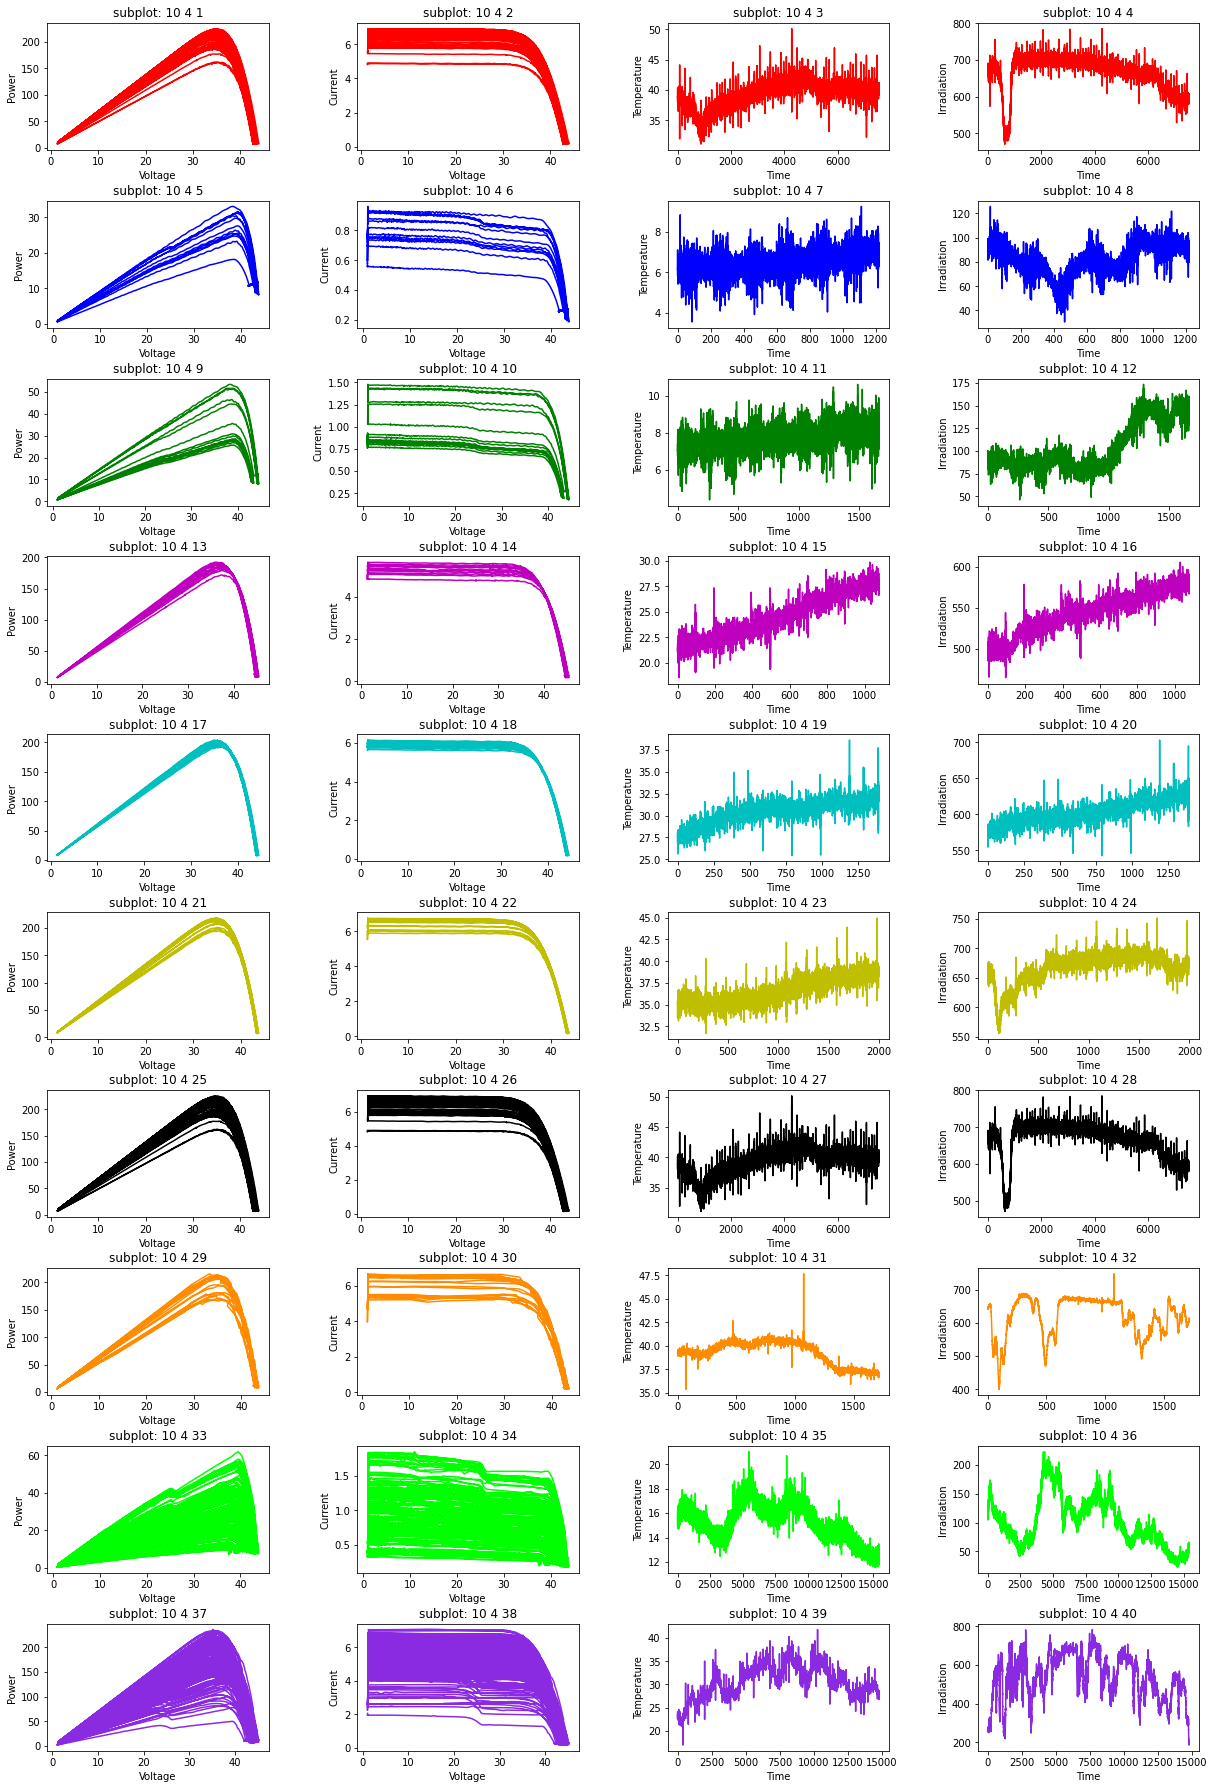

In [ ]:
k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis

a = 10  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
itm=0
color=0


fig = plt.figure(figsize=(20,30))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(10): 
  index=0 
  for j in range(4):
    plt.subplot(a, b, c)
    plt.title('subplot: {} {} {}'.format( a, b, c))
    plt.xlabel(Xlab[index])
    plt.ylabel(Ylab[index])
    plt.plot(df[X[itm]], df[Y[itm]],k1[color]) #,label=k2[index]
    c = c + 1
    itm= itm + 1
    index=index+1
  color=color+1
  
plt.show()

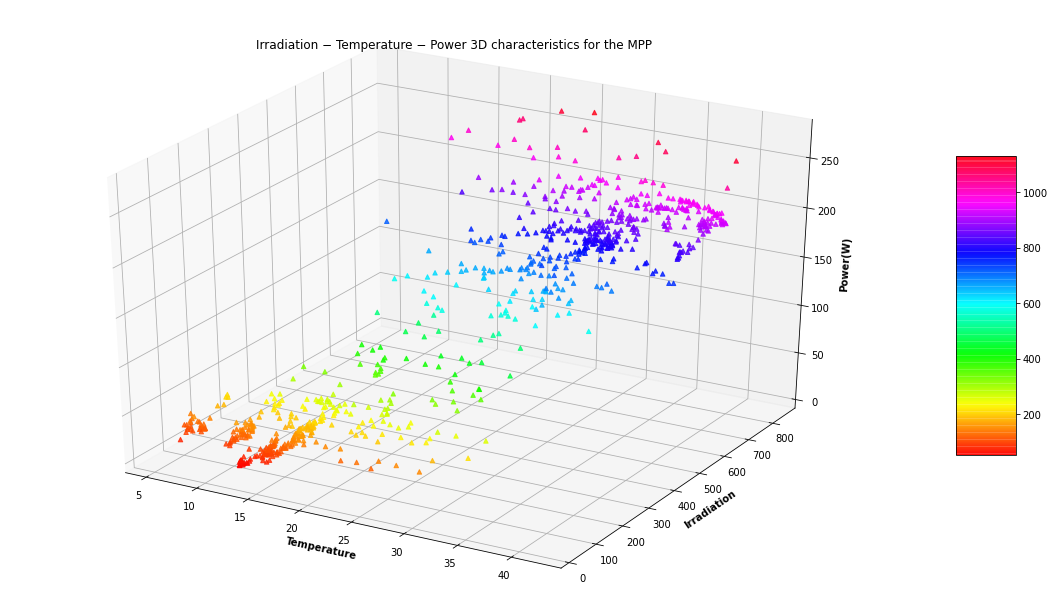

In [ ]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df1['T']
y=df1['G']
z=df1['Pmax']
sctt = ax.scatter3D(x, y, z,
                    alpha = .8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Irradiation − Temperature − Power 3D characteristics for the MPP")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()



# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	

# 3D without color
# threedee = plt.figure(figsize = (12, 8)).gca(projection='3d')
# threedee.scatter(df['T'], df['G'], df['Pmax'])
# threedee.set_xlabel('Temperature')
# threedee.set_ylabel('Irradiation')
# threedee.set_zlabel('Power(W)')
# plt.show()

#converting spark dataframe to pandas dataframe aiming to use matplotlib
# pdf = sdf.toPandas()

## Filtring the Temperature and Irradiation signals

In [ ]:

# determination of x-axis and y-axis 
col=df.columns
Time=[]   
Temperature=[]
Irradiation=[]
Current=[]
Voltage=[]
Power=[]

for i in range(0,len(col),6):
  index=col[i] 
  Time.append(index)
  index=col[i+1] 
  Temperature.append(index)
  index=col[i+2]
  Irradiation.append(index)
  index=col[i+3] 
  Current.append(index)
  index=col[i+4] 
  Voltage.append(index)
  index=col[i+5] 
  Power.append(index)


# convert list to array
Time=np.array(Time)
Temperature=np.array(Temperature)
Irradiation=np.array(Irradiation)
Current=np.array(Current)
Voltage=np.array(Voltage)
Power=np.array(Power)


print(Time,'\n', Temperature,'\n',Irradiation,'\n',Current,'\n',Voltage,'\n',Power)



['Time' 'Time01' 'Time02' 'Time03' 'Time04' 'Time05' 'Time06' 'Time07'
 'Time08' 'Time09' 'Time10'] 
 ['T_pv00' 'T_pv01' 'T_pv02' 'T_pv03' 'T_pv04' 'T_pv05' 'T_pv06' 'T_pv07'
 'T_pv08' 'T_pv09' 'T_pv10'] 
 ['G_pv00' 'G_pv01' 'G_pv02' 'G_pv03' 'G_pv04' 'G_pv05' 'G_pv06' 'G_pv07'
 'G_pv08' 'G_pv09' 'G_pv10'] 
 ['I_pv00' 'I_pv01' 'I_pv02' 'I_pv03' 'I_pv04' 'I_pv05' 'I_pv06' 'I_pv07'
 'I_pv08' 'I_pv09' 'I_pv10'] 
 ['V_pv00' 'V_pv01' 'V_pv02' 'V_pv03' 'V_pv04' 'V_pv05' 'V_pv06' 'V_pv07'
 'V_pv08' 'V_pv09' 'V_pv10'] 
 ['P_pv00' 'P_pv01' 'P_pv02' 'P_pv03' 'P_pv04' 'P_pv05' 'P_pv06' 'P_pv07'
 'P_pv08' 'P_pv09' 'P_pv10']


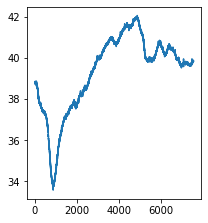

In [ ]:
# Define the filter requirements
T = 5.0         # Sample Period
fs = 200.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis
a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter
itm=0
color=0
fig = plt.figure(figsize=(20,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    F = filtfilt(b, a, data)
    return F




# for j in range(0,len(Temperature)-1):
data=df[Temperature[0]]
F1 = butter_lowpass_filter(data, cutoff, fs, order)
plt.subplot(a, b, c)
plt.plot(df[Time[0]], F1)
# data=df[Irradiation[j]]
# F = butter_lowpass_filter(data, cutoff, fs, order)
c = c + 1


  
# plt.show()







##Loading data into a Spark DataFrame





In [ ]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- Time: double (nullable = true)
 |-- T_pv00: double (nullable = true)
 |-- G_pv00: double (nullable = true)
 |-- I_pv00: double (nullable = true)
 |-- V_pv00: double (nullable = true)
 |-- P_pv00: double (nullable = true)
 |-- Time01: double (nullable = true)
 |-- T_pv01: double (nullable = true)
 |-- G_pv01: double (nullable = true)
 |-- I_pv01: double (nullable = true)
 |-- V_pv01: double (nullable = true)
 |-- P_pv01: double (nullable = true)
 |-- Time02: double (nullable = true)
 |-- T_pv02: double (nullable = true)
 |-- G_pv02: double (nullable = true)
 |-- I_pv02: double (nullable = true)
 |-- V_pv02: double (nullable = true)
 |-- P_pv02: double (nullable = true)
 |-- Time03: double (nullable = true)
 |-- T_pv03: double (nullable = true)
 |-- G_pv03: double (nullable = true)
 |-- I_pv03: double (nullable = true)
 |-- V_pv03: double (nullable = true)
 |-- P_pv03: double (nullable = true)
 |-- Time04: double (nullable = true)
 |-- T_pv04: double (nullable = true)
 |-- G_pv

In [ ]:
sdf1 = spark.createDataFrame(df1)

sdf1.printSchema()

root
 |-- Pmax: double (nullable = true)
 |-- Vmax: double (nullable = true)
 |-- Imax: double (nullable = true)
 |-- G: double (nullable = true)
 |-- T: double (nullable = true)



##Converting data frame columns into feature vectors

In [ ]:
assembler1 = VectorAssembler(
    inputCols=["T", "G"],
    outputCol="features1")

assembler2 = VectorAssembler(
    inputCols=["T", "Pmax"],
    outputCol="features2")

assembler3 = VectorAssembler(
    inputCols=["G", "Pmax"],
    outputCol="features3")

# Output voltage
output1 = assembler1.transform(sdf1).select('features1','Vmax')
output2 = assembler2.transform(sdf1).select('features2','Vmax')
output3 = assembler3.transform(sdf1).select('features3','Vmax')

# Output Current
output4 = assembler1.transform(sdf1).select('features1','Imax')
output5 = assembler2.transform(sdf1).select('features2','Imax')
output6 = assembler3.transform(sdf1).select('features3','Imax')


train1, test1 = output1.randomSplit([0.75, 0.25])
train2, test2 = output2.randomSplit([0.75, 0.25])
train3, test3 = output3.randomSplit([0.75, 0.25])
train4, test4 = output4.randomSplit([0.75, 0.25])
train5, test5 = output5.randomSplit([0.75, 0.25])
train6, test6 = output6.randomSplit([0.75, 0.25])

#stats

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

In [ ]:
corr1 = Correlation.corr(train1, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr6[0]))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Pearson correlation matrix:
DenseMatrix([[1.        , 0.86452409],
             [0.86452409, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.86024813],
             [0.86024813, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99760026],
             [0.99760026, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.85699016],
             [0.85699016, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.84179948],
             [0.84179948, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99758892],
             [0.99758892, 1.        ]])


### b) *Spearman* correlation

In [ ]:

corr1 = Correlation.corr(train1, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr6[0]))


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Spearman correlation matrix:
DenseMatrix([[1.        , 0.83810477],
             [0.83810477, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.       , 0.8299945],
             [0.8299945, 1.       ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99529941],
             [0.99529941, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.       , 0.8290041],
             [0.8290041, 1.       ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.79863858],
             [0.79863858, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99542154],
             [0.99542154, 1.        ]])


##2) Normalization

##3) Standardization

# Training

In [ ]:
#upload data from local machine

# uploaded = files.upload()  
# data= io.BytesIO(uploaded['PV_all_data.xlsx'])
# df = pd.read_excel(data)

# upload Excel data from git
# url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'